# Assumptions and numerical validations

The hypothesis tests described in the previous notebook (`4-HypothesisTests`) assume that the functional residuals are normally distributed at each grid point in the 1D domain. This assumption has been found to be reasonable for a variety of biomechanical variables (Pataky et al. 2015) but it has not been previously considered for warping functions. The purpose of this notebook is to briefly consider the warp function characteristics for which the domain-wise normality assumption may be valid.

⚠️ Note that the normality assumption is generally **not** valid when warping functions are very smooth. This notebook summarizes a numerical argument for validity in the case of rough warping functions. No mathematical proofs are provided. 

<br>
<br>

Let's first import the packages we'll need for this notebook:

<br>
<br>

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import spm1d
from spm1d import rft1d
import nlreg1d as nl

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Parametric survival functions for smooth 1D Gaussian data

Random field theory (RFT) parametrically describes various probabilities associated with Gaussian-distributed functional data, including especially the expected distribution of the maximum test statistic value. Let's start with a quick one-sample simulation to verify that Gaussian functional data conform to `rft1d`'s expectations. The key hypopthesis testing-relevant probability calculation is the survival function $P(t_{\max}>u)$, which represents the probability that the maximum t-value ($t_{\max}$) exceeds an arbitrary threshold *u*. This survival function can be calculated using `rft.t.sf` as indicated below.


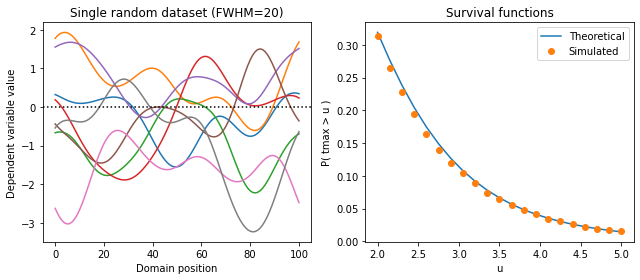

In [2]:
def tstat(y): # one-sample t statistic
    return y.mean(axis=0) / y.std(ddof=1, axis=0) * (y.shape[0]**0.5)


np.random.seed(12345)
J         = 8      # number of observations
Q         = 101    # number of grid points
FWHM      = 20     # full-width-at-half-maximum (related to the Lipschitz-Killing curvature)
v         = J - 1  # degress of freedom
nsim      = 5000   # number of simulated datasets
tmax      = []
for i in range(nsim):
    y     = rft1d.randn1d(J, Q, FWHM)
    t     = tstat( y )
    tmax.append( t.max() )

# survival functions:
u         = np.linspace(2, 5, 21)
sf        = np.array( [ (tmax>uu).mean()  for uu in u] )  # simulation results
sfe       = rft1d.t.sf(u, v, Q, FWHM)                     # expected

# plot:
fig,axs = plt.subplots(1, 2, figsize=(9,4))

ax0,ax1 = axs
ax0.plot(y.T)
ax0.axhline(0, color='k', ls=':')
ax0.set_title( f'Single random dataset (FWHM={FWHM})' )
ax0.set_xlabel('Domain position')
ax0.set_ylabel('Dependent variable value')

ax1.plot(u, sfe, '-', label='Theoretical')
ax1.plot(u, sf,  'o', label='Simulated')
ax1.set_xlabel('u')
ax1.set_ylabel('P( tmax > u )')
ax1.legend()
ax1.set_title( f'Survival functions' )

plt.tight_layout()
plt.show()

The simulation results conform to random field theory (RFT) expectations. Refer to the main [rft1d paper](https://doi.org/10.18637/jss.v071.i07) and the [documentation](https://spm1d.org/rft1d/) for mathematical details and additional numerical validations.

<br>
<br>

## Qualitative point distributions of random warping functions

Let's next check the distributions of random warping functions. See the `2-Warps` notebook for additional details regarding warps.

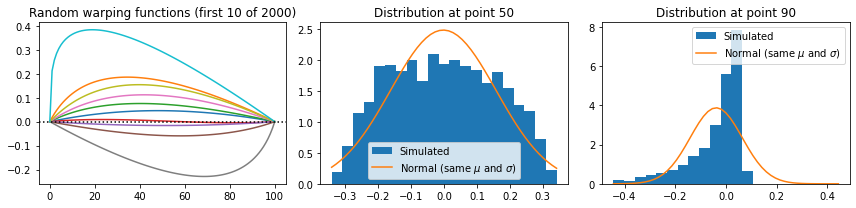

In [3]:
np.random.seed(12345)
J     = 2000     # number of observations
Q     = 101      # number of grid points (equally spaced)
w     = nl.random_warp( J, Q, sigma=1, shape_parameter=100, n_random=5, as_warp_object=True )
# d     = w.get_deviation_from_linear_time()
d     = w.get_displacement_field()
inds  = [50, 90] # points at which to consider the distribution


# create figure:
fig,axs = plt.subplots(1, 3, figsize=(12,3))
ax0,ax1,ax2 = axs

# plot random warp functions
ax0.plot( d[:10].T )
ax0.axhline(color='k', ls=':')
ax0.set_title( f'Random warping functions (first 10 of {J})' )

# plot warp function value distributions at two domain points:
for ax,ind in zip(axs[1:], inds):
    dd      = d[:,ind]
    x0,x1   = dd.min(), dd.max()
    x0,x1   = (-x1,x1) if (x1 > abs(x0)) else (x0,-x0)
    # observed distribution:
    ax.hist( dd, bins=21, range=(x0,x1), density=True, label='Simulated' )
    # theoretical distribution:
    x       = np.linspace(x0, x1, 51)
    pdf     = stats.norm.pdf(x, dd.mean(), dd.std(ddof=1))
    ax.plot(x, pdf, label='Normal (same $\mu$ and $\sigma$)')
    ax.legend()
    ax.set_title( f'Distribution at point {ind}' )

plt.tight_layout()
plt.show()

The warp function distribution at point 50 looks approximately normal, but clearly the distribution at point 90 is non-normal.

However, note that the warp functions are very smooth, and thus qualitatively dissimilar to the warping functions calculated during nonlinear registration for experimental data. For example:

Initializing...
Compute Karcher Mean of 41 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
maximal number of iterations is reached


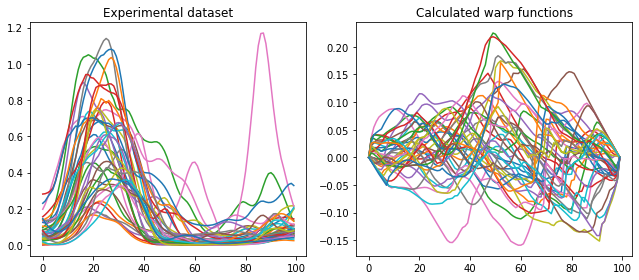

Initializing...
Compute Karcher Mean of 12 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 20 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 41 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 20 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
maximal number of iterations is reached


In [4]:
dataset   = nl.data.Besier2009VastusForce()
y         = dataset.dv
yr,wf     = nl.register_srsf(y, MaxItr=5)
wlist     = nl.Warp1DList( wf )
# d         = wlist.get_deviation_from_linear_time()
d         = wlist.get_displacement_field()

fig,axs   = plt.subplots(1, 2, figsize=(9,4))
ax0,ax1   = axs
ax0.plot(y.T)
ax1.plot(d.T)
ax0.set_title('Experimental dataset')
ax1.set_title('Calculated warp functions')
plt.tight_layout()
plt.show()


Simulating rougher warp functions like these can be achieved by adjusting various `random_warp` parameters (like `shape_parameter` and `n_random`), like this:

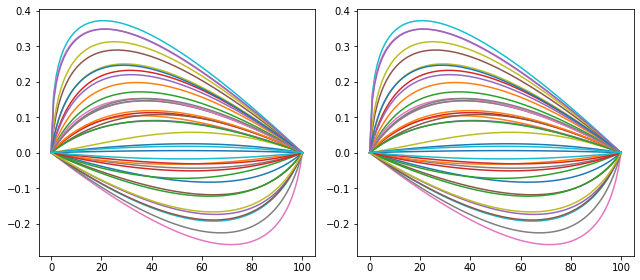

In [5]:
np.random.seed(1234567)
J   = 40
Q   = 101
w0  = nl.random_warp( J, Q, sigma=1, shape_parameter=100, n_random=5, as_warp_object=True )
w1  = nl.random_warp( J, Q, sigma=1, shape_parameter=0.01, n_random=25, as_warp_object=True )
# y0  = w0.get_deviation_from_linear_time()
# y1  = w1.get_deviation_from_linear_time()
y0  = w0.get_displacement_field()
y1  = w0.get_displacement_field()


fig,axs   = plt.subplots(1, 2, figsize=(9,4))
ax0,ax1   = axs
ax0.plot(y0.T)
ax1.plot(y1.T)
# ax0.set_title('Experimental dataset')
# ax1.set_title('Calculated warp functions')
plt.tight_layout()
plt.show()

Note that the warp functions on the right are qualitatively much more similar to the experimental dataset's warp functions than those on the left. Let's repeat or qualitatively distribution check, this time using rougher warping functions like those in the right panel above:

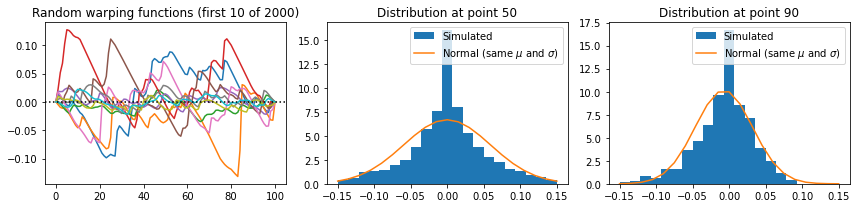

In [6]:
np.random.seed(123456)
J     = 2000     # number of observations
Q     = 101      # number of grid points (equally spaced)
# w     = nl.random_warp( J, Q, sigma=0.1, shape_parameter=0.01, n_random=30, as_warp_object=True )
w     = nl.random_warp( J, Q, sigma=1, shape_parameter=0.01, n_random=25, as_warp_object=True )
# d     = w.get_deviation_from_linear_time()
d     = w.get_displacement_field()
inds  = [50, 90] # points at which to consider the distribution


# create figure:
fig,axs = plt.subplots(1, 3, figsize=(12,3))
ax0,ax1,ax2 = axs

# plot random warp functions
ax0.plot( d[:10].T )
ax0.axhline(color='k', ls=':')
ax0.set_title( f'Random warping functions (first 10 of {J})' )

# plot warp function value distributions at two domain points:
x0,x1 = -0.15, 0.15
for ax,ind in zip(axs[1:], inds):
    dd      = d[:,ind]
#     x0,x1   = dd.min(), dd.max()
#     x0,x1   = (-x1,x1) if (x1 > abs(x0)) else (x0,-x0)
    # observed distribution:
    ax.hist( dd, bins=21, range=(x0,x1), density=True, label='Simulated' )
    # theoretical distribution:
    x       = np.linspace(x0, x1, 21)
    pdf     = stats.norm.pdf(x, dd.mean(), dd.std(ddof=1))
    ax.plot(x, pdf, label='Normal (same $\mu$ and $\sigma$)')
    ax.legend()
    ax.set_title( f'Distribution at point {ind}' )

plt.tight_layout()
plt.show()

The distribution at domain point 90 appears somewhat more normal, but the distribution at point 50 looks somewhat less normal. So we haven't learned much from these distributions other than: distributions near the domain endpoints appear to be become increasingly normally distributed as warping roughness increases. Let's next consider the probabilistic behavior of these warp functions in more detail.

<br>
<br>

## Parametric survival functions for warping functions

If RFT's assumption of normality is valid, then simulation results (involving random warps) should produce survival function results similar to the ones for known Gaussian data (two sections above), where the simulation results conform to RFT's theoretical expectations. Let's modify the simulation code to include random warps rather then known Gaussian data. 

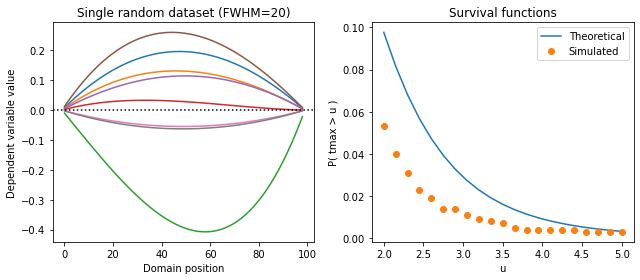

In [7]:
np.random.seed(12345)
J         = 8      # number of observations
Q         = 101    # number of grid points
v         = J - 1  # degress of freedom
nsim      = 1000   # number of simulated datasets
tmax      = []
fwhme     = []     # esimated FWHM (smoothness)
for i in range(nsim):
    w     = nl.random_warp( J, Q, sigma=1, shape_parameter=100, n_random=5, as_warp_object=True )
    y     = w.get_deviation_from_linear_time()[:,1:-1]
    t     = tstat( y )
    tmax.append( t.max() )
    fwhme.append( nl.util.estimate_fwhm(y) )

# survival functions:
u         = np.linspace(2, 5, 21)
sf        = np.array( [ (tmax>uu).mean()  for uu in u] )  # simulation results
sfe       = rft1d.t.sf(u, v, Q, np.mean(fwhme))           # expected

# plot:
fig,axs = plt.subplots(1, 2, figsize=(9,4))

ax0,ax1 = axs
ax0.plot(y.T)
ax0.axhline(0, color='k', ls=':')
ax0.set_title( f'Single random dataset (FWHM={FWHM})' )
ax0.set_xlabel('Domain position')
ax0.set_ylabel('Dependent variable value')

ax1.plot(u, sfe, '-', label='Theoretical')
ax1.plot(u, sf,  'o', label='Simulated')
ax1.set_xlabel('u')
ax1.set_ylabel('P( tmax > u )')
ax1.legend()
ax1.set_title( f'Survival functions' )

plt.tight_layout()
plt.show()




These random warps adhere much less well to RFT's expectations.

How about rougher warping functions?

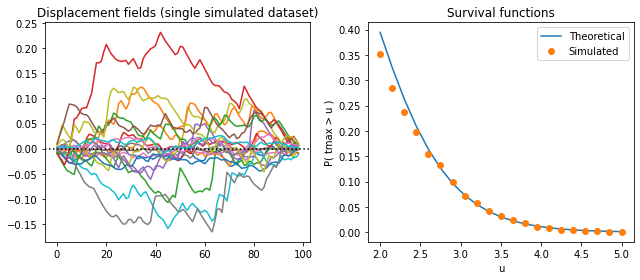

In [8]:
np.random.seed(12345)
J         = 20     # number of observations
Q         = 101    # number of grid points
v         = J - 1  # degress of freedom
nsim      = 1000   # number of simulated datasets
tmax      = []
fwhme     = []     # estimated FWHM
for i in range(nsim):
    w     = nl.random_warp( J, Q, sigma=1, shape_parameter=0.01, n_random=50, as_warp_object=True )
    y     = w.get_deviation_from_linear_time()[:,1:-1]
    t     = tstat( y )
    tmax.append( t.max() )
    fwhme.append( nl.util.estimate_fwhm(y) )

# survival functions:
u         = np.linspace(2, 5, 21)
sf        = np.array( [ (tmax>uu).mean()  for uu in u] )  # simulation results
sfe       = rft1d.t.sf(u, v, Q, np.mean(fwhme))           # expected

# plot:
fig,axs = plt.subplots(1, 2, figsize=(9,4))

ax0,ax1 = axs
ax0.plot(y.T)
ax0.axhline(0, color='k', ls=':')
ax0.set_title( f'Displacement fields (single simulated dataset)' )

ax1.plot(u, sfe, '-', label='Theoretical')
ax1.plot(u, sf,  'o', label='Simulated')
ax1.set_xlabel('u')
ax1.set_ylabel('P( tmax > u )')
ax1.legend()
ax1.set_title( f'Survival functions' )

plt.tight_layout()
plt.show()

These results anecdotally suggest that rougher warping functions adhere more closely to RFT expectations.

## Nonparametric analysis

If RFT's main assumption (of normally distributed residuals at each domain point) were invalid, one would expect nonparametric results to diverge from RFT's parametric results. The analyses below compare statistical nonparametric mapping (SnPM) (see [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6871862/) and [here](https://link.springer.com/article/10.1007/s10182-021-00418-4)) results to their parametric counterparts;  note that SnPM is equivalent to the "Fmax" procedure in functional data analysis.

### Dataset:  SimulatedA

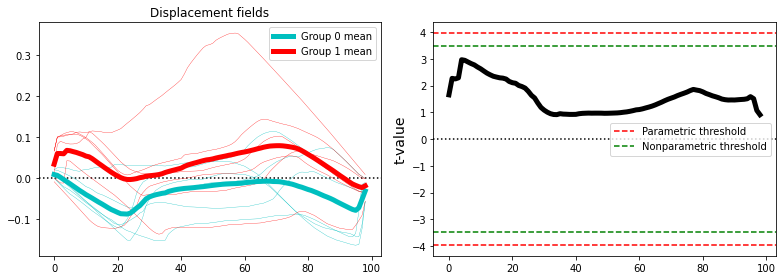

In [9]:
nperms  = 10000    # number of permutations (for nonparametric inference)
np.random.seed(0)

# load data:
dataset = nl.data.SimulatedA()


def run_tests(dataset, alpha=0.05, paired=False):
    # assemble dependent variable:
    group   = dataset.group
    y       = dataset.dv
    n       = (group==0).sum()     # number of observations in first group
    # register:
    yr,wf   = nl.register_srsf(y, MaxItr=5)
    wlist   = nl.Warp1DList( wf )
    d       = wlist.get_displacement_field()[:,1:-1]
    d0,d1   = d[:n], d[n:]
    if paired:
        ti  = spm1d.stats.ttest_paired( d1, d0 ).inference(alpha, two_tailed=True)  # parametric
        tn  = spm1d.stats.nonparam.ttest_paired( d1, d0 )  # nonparametric
    else:
        ti  = spm1d.stats.ttest2( d1, d0 ).inference(alpha, two_tailed=True)
        tn  = spm1d.stats.nonparam.ttest2( d1, d0 )
    iters   = min(nperms, tn.permuter.nPermTotal)
    tni     = tn.inference(alpha, iterations=iters, two_tailed=True)  # nonparametric inference
    return d0, d1, ti, tni


def plot_results(d0, d1, spm, snpm):
    fig,axs = plt.subplots( 1, 2, figsize=(11,4) )
    ax0,ax1 = axs
    # plot displacement fields:
    ax0.axhline(0, color='k', ls=':')
    ax0.plot(d0.T, 'c', lw=0.3)
    ax0.plot(d1.T, 'r', lw=0.3)
    ax0.plot(d0.mean(axis=0), 'c', lw=5, label='Group 0 mean')
    ax0.plot(d1.mean(axis=0), 'r', lw=5, label='Group 1 mean')
    ax0.legend()
    ax0.set_title('Displacement fields')
    # plot test statistic results:
    ax1.plot(ti.z, 'k', lw=5)
    ax1.axhline(0, color='k', ls=':')
    h0 = [ax1.axhline(z, color='r', ls='--')  for z in [ti.zstar, -ti.zstar]][0]
    h1 = [ax1.axhline(z, color='g', ls='--')  for z in [tni.zstar, -tni.zstar]][0]
    ax1.set_ylabel('t-value', size=14)
    ax1.legend([h0,h1], ['Parametric threshold','Nonparametric threshold'])
    plt.tight_layout()
    plt.show()
    

d0,d1,ti,tni = run_tests( dataset, alpha=0.05, paired=False )

plot_results(d0, d1, ti, tni)

### Dataset:  Simulated B

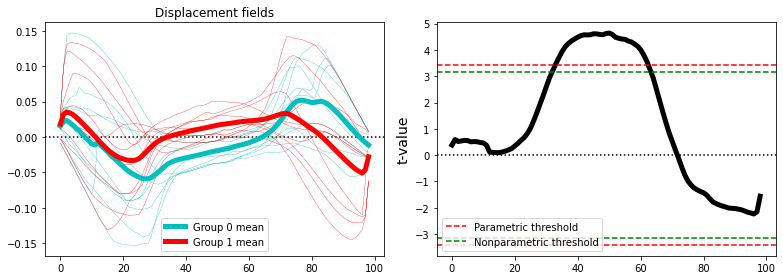

In [10]:
np.random.seed(1)
dataset      = nl.data.SimulatedB()
d0,d1,ti,tni = run_tests( dataset, alpha=0.05, paired=False )
plot_results(d0, d1, ti, tni)

### Dataset:  Besier2009VastusForce

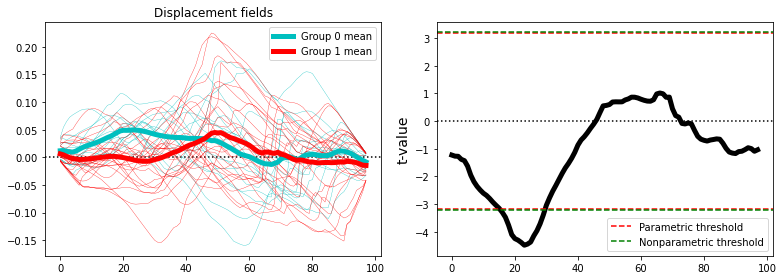

In [11]:
np.random.seed(2)
dataset      = nl.data.Besier2009VastusForce()
d0,d1,ti,tni = run_tests( dataset, alpha=0.05, paired=False )
plot_results(d0, d1, ti, tni)

### Dataset:  Pataky2014MediolateralCOP

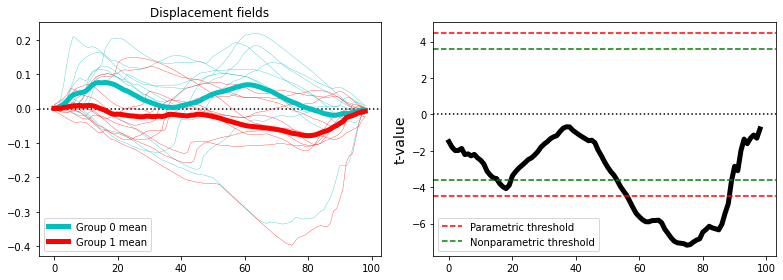

In [12]:
np.random.seed(3)
dataset      = nl.data.Pataky2014MediolateralCOP()
d0,d1,ti,tni = run_tests( dataset, alpha=0.05, paired=True )
plot_results(d0, d1, ti, tni)

From these analyses we can see that:

- In all datasets, there are numerical differences between the parametric and nonparametric critical thresholds
- However, these differences are not large enough to change the null hypothesis rejection decision, for any of these datasets
- Moreover, these differences are sufficiently small that *post hoc* considerations of suprathreshold cluster locations are affected only for one dataset (the final one: Pataky2014MediolateralCOP)
- The differences in parametric and non-parametric results are therefore largely inconsequential for these datasets
- Thus RFT's assumption of normally distributed residuals (in the warp displacement fields) appears to be a resonable one for these datasets

### References

Pataky, T. C., Vanrenterghem, J., & Robinson, M. A. (2015). [Zero-vs. one-dimensional, parametric vs. non-parametric, and confidence interval vs. hypothesis testing procedures in one-dimensional biomechanical trajectory analysis](https://doi.org/10.1016/j.jbiomech.2015.02.051). Journal of Biomechanics, 48(7), 1277-1285.